## Weights from GM model

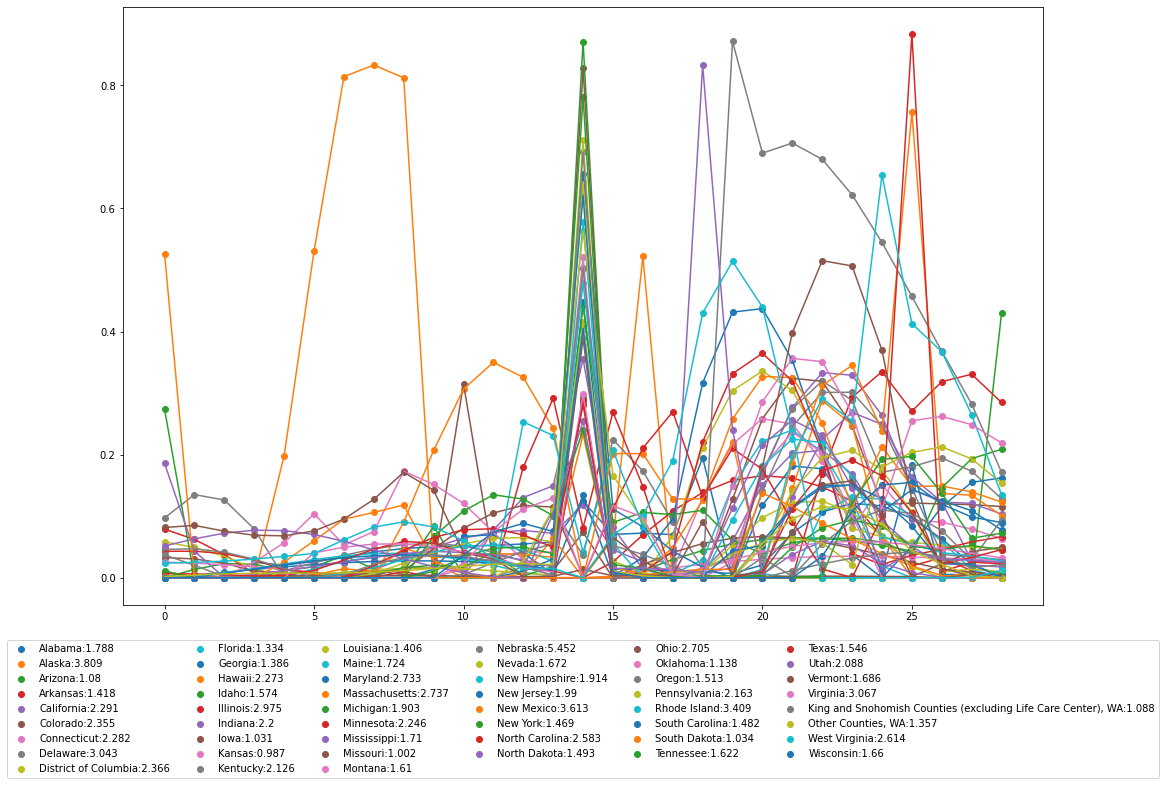

In [11]:
import dill as pickle
import matplotlib.pyplot as plt

from db_queries import get_location_metadata

loc_df = get_location_metadata(location_set_version_id=630, location_set_id=111)
loc_df = loc_df.loc[loc_df['path_to_top_parent'].str.startswith('102,')]
loc_df = loc_df.loc[loc_df['most_detailed'] == 1]
loc_df = loc_df.loc[~loc_df['location_id'].isin([573, 60406])]
loc_id = 555

plt.figure(figsize=(16.5, 11))
for loc_id in loc_df.location_id:
    with open(f'/ihme/covid-19/deaths/dev/2020_04_25_US_point/model_data_google_21/{loc_id}/gaussian_mixtures.pkl', 'rb') as fopen:
        gm = pickle.load(fopen)

    plt.scatter(np.arange(gm[f'_{loc_id}'].weights.size),
                gm[f'_{loc_id}'].weights, 
                label = f"{loc_df.loc[loc_df['location_id'] == loc_id, 'location_name'].item()}:{np.round(gm[f'_{loc_id}'].weights.sum(), 3)}")
    plt.plot(np.arange(gm[f'_{loc_id}'].weights.size),
                gm[f'_{loc_id}'].weights)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)
plt.show()


## Play around with down-sampling

In [ ]:
import os

import dill as pickle

import numpy as np
import pandas as pd

from scipy.signal import resample

import matplotlib.pyplot as plt


location_name = 'California'
location_id = '_527'
pop = 36.9e6
n_draws = 111

with open(f'/ihme/covid-19/deaths/prod/2020_04_13_US/model_data_equal_21/{location_name}/draws.pkl', 'rb') as fopen:
    draws = pickle.load(fopen)

orig_draws = np.exp(draws[location_id][1]) * pop
# ds_draws = np.arange(orig_draws.shape[0], step=orig_draws.shape[0]/n_draws)
# ds_draws = [int(i) for i in ds_draws]
# assert len(ds_draws) == n_draws, 'Draw length not correct.'
# downsample_draws = orig_draws[ds_draws]
downsample_draws = resample(orig_draws, n_draws, axis=0)
downsample_draws = downsample_draws[np.argsort(downsample_draws[:,-1]),:]

orig_draws = orig_draws[:,1:] - orig_draws[:,:-1]
downsample_draws = downsample_draws[:,1:] - downsample_draws[:,:-1]

plt.figure(figsize=(11, 8.5))
plt.fill_between(draws[location_id][0][1:],
                np.percentile(orig_draws, 2.5, axis=0),
                np.percentile(orig_draws, 97.5, axis=0),
                color='dodgerblue', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         orig_draws.mean(axis=0), color='dodgerblue', label='Full draws')
plt.fill_between(draws[location_id][0][1:],
                np.percentile(downsample_draws, 2.5, axis=0),
                np.percentile(downsample_draws, 97.5, axis=0),
                color='firebrick', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         downsample_draws.mean(axis=0), color='firebrick', label='Downsampled draws', linestyle='--')
plt.legend(loc=2)
plt.show()


In [ ]:
?resample

## plot peaks (should add data to this)

In [ ]:
import matplotlib.pyplot as plt

pred_df = pd.read_csv(f'{OUTPUT_DIR}/point_estimates.csv', index=False)
pred_df['Date']
peak_dates_df = pd.read_csv(f'{OUTPUT_DIR}/peak_dates.csv', index=False)

for location_id in pred_df.location_id.unique():
    plt.plot(pred_df.loc[pred_df['location_id'] == location_id, 'Date'],
             pred_df.loc[pred_df['location_id'] == location_id, 'Daily death rate'],
             color='dodgerblue')
    plt.axvline(peak_dates_df.loc[peak_dates_df['location_id'] == location_id, 'Date'].item(),
                color='red', linestyle='--')
    plt.title(location_id)
    plt.show()


## plot raw + smoothed data, then predicted

/ihme/covid-19/miniconda/envs/covid-deaths-2020-05-02_07-29-59/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/ihme/covid-19/miniconda/envs/covid-deaths-2020-05-02_07-29-59/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


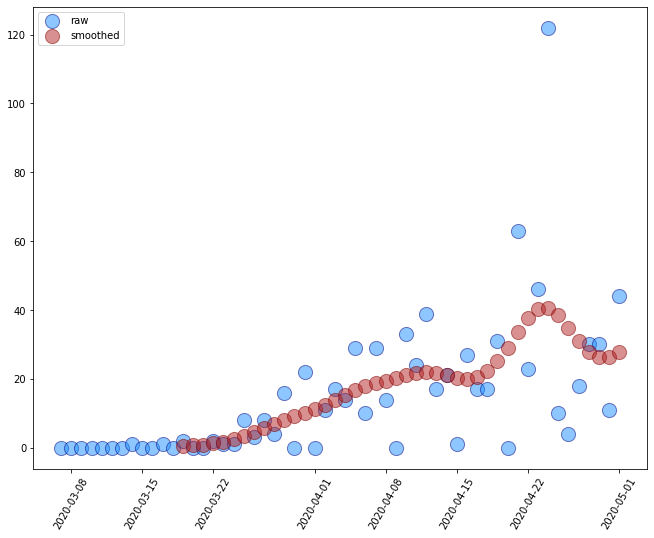

In [5]:
location_id = 528

draw_cols = [f'draw_{d}' for d in range(1000)]

smooth_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_05_01_US_newmod/smoothed_state_data.csv')
smooth_df = smooth_df.loc[smooth_df['location_id'] == location_id]
smooth_df['date'] = pd.to_datetime(smooth_df['date'])
smooth_df = smooth_df.sort_values('date').reset_index(drop=True)

raw_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_05_01_US_newmod/state_data.csv')
raw_df = raw_df.loc[raw_df['location_id'] == location_id]
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.sort_values('date').reset_index(drop=True)

smooth_delta = (smooth_df[draw_cols].values[1:] - smooth_df[draw_cols].values[:-1]).mean(axis=1)
raw_delta = (raw_df[draw_cols].values[1:] - raw_df[draw_cols].values[:-1]).mean(axis=1)

smooth_df['daily'] = np.nan
smooth_df['daily'][1:] = smooth_delta
raw_df['daily'] = np.nan
raw_df['daily'][1:] = raw_delta

smooth_df = smooth_df[['date', 'observed', 'daily']][1:].reset_index(drop=True)
raw_df = raw_df[['date', 'observed', 'daily']][1:].reset_index(drop=True)

pred_date = raw_df.loc[~raw_df['observed'], 'date'].min()

import matplotlib.pyplot as plt

plt.figure(figsize=(11, 8.5))
plt.scatter(raw_df.loc[raw_df['date'] < pred_date, 'date'], 
            raw_df.loc[raw_df['date'] < pred_date, 'daily'], 
            c='dodgerblue', edgecolors='navy', alpha=0.5, s=200, label='raw')
plt.scatter(smooth_df.loc[smooth_df['date'] < pred_date, 'date'], 
            smooth_df.loc[smooth_df['date'] < pred_date, 'daily'], 
            c='firebrick', edgecolors='maroon', alpha=0.5, s=200, label='smoothed')
# plt.plot(smooth_df['date'], 
#          smooth_df['daily'], 
#          color='darkgrey', linestyle='--')
plt.xticks(rotation=60)
plt.legend(loc=2)
plt.show()


## look at testing effect

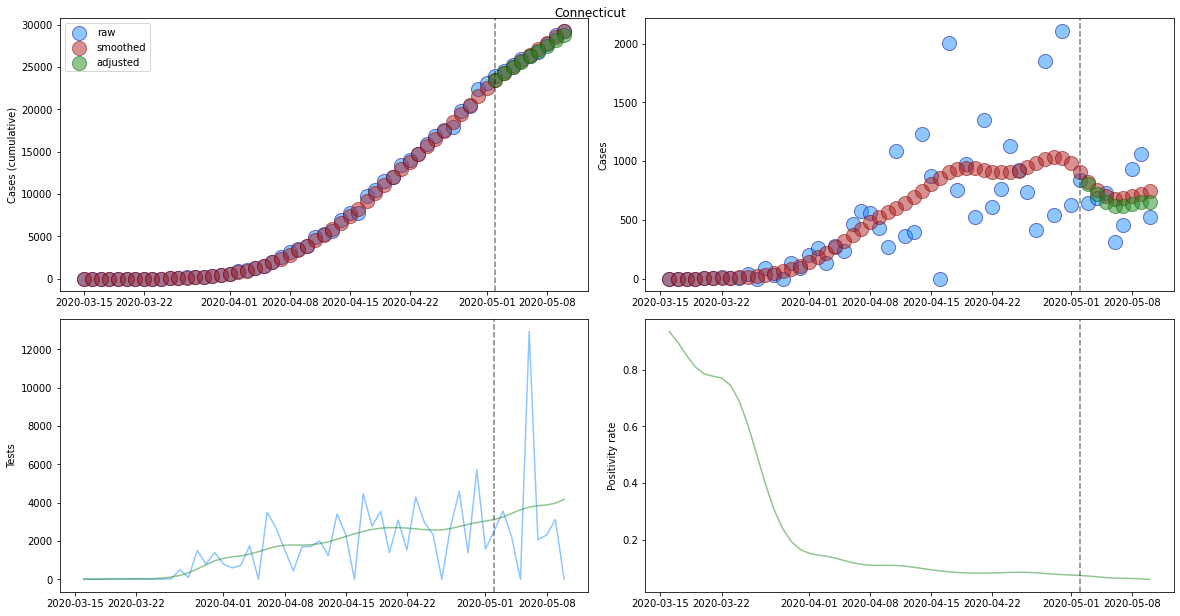

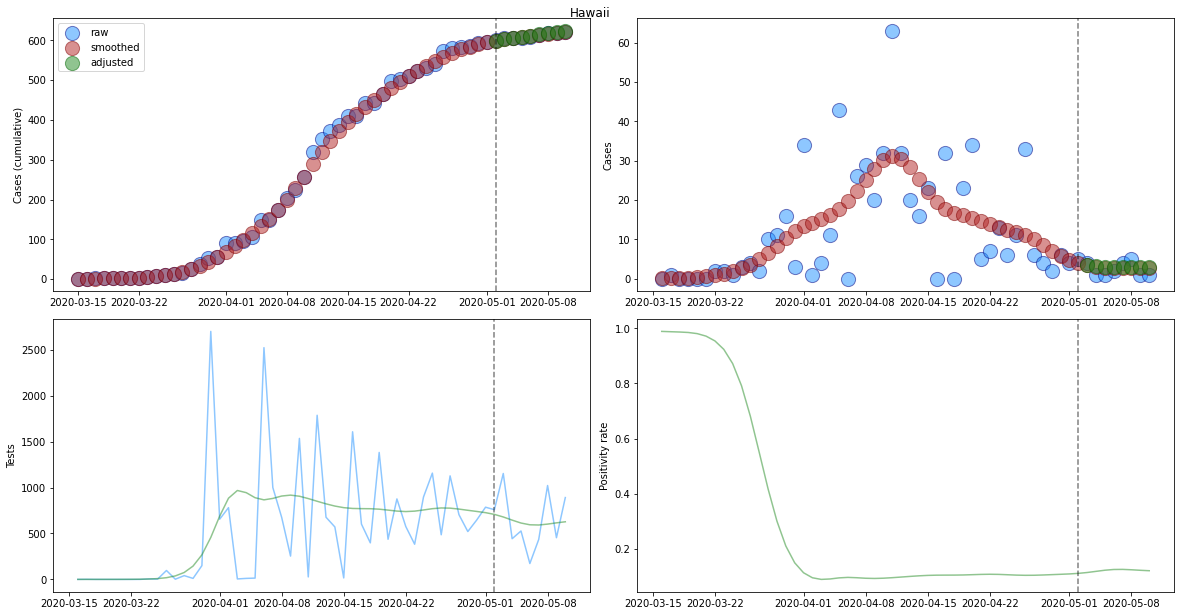

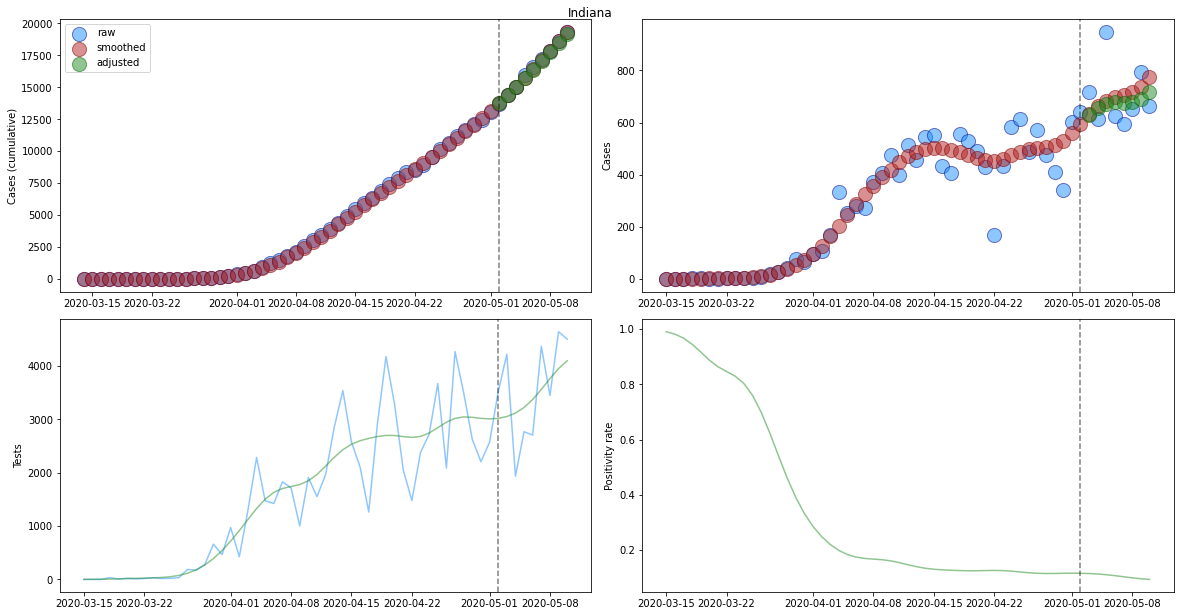

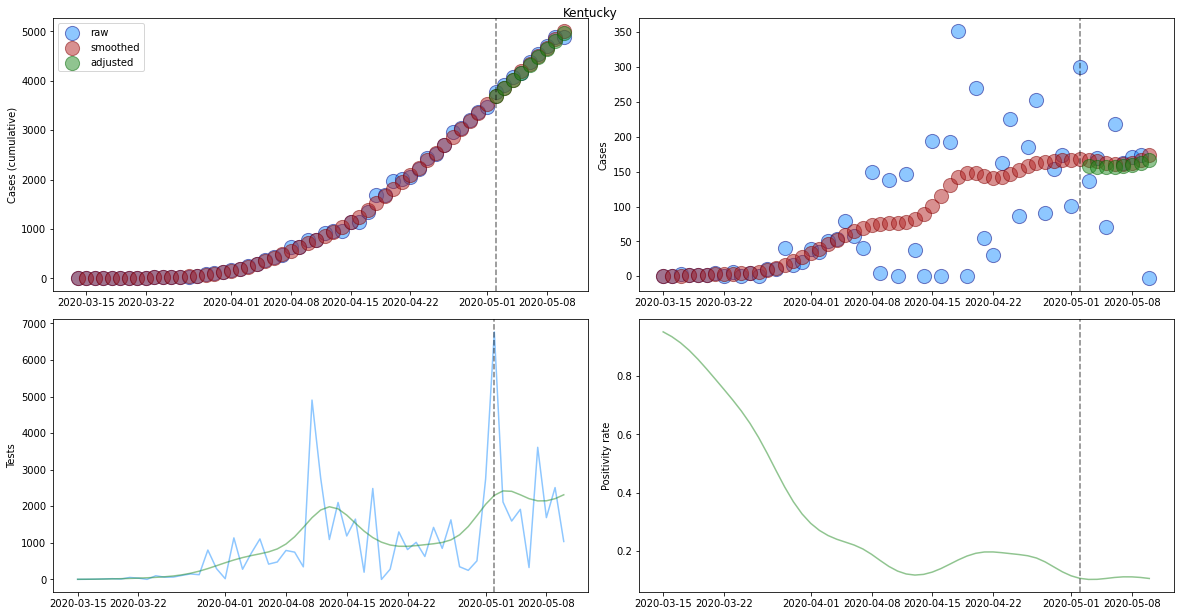

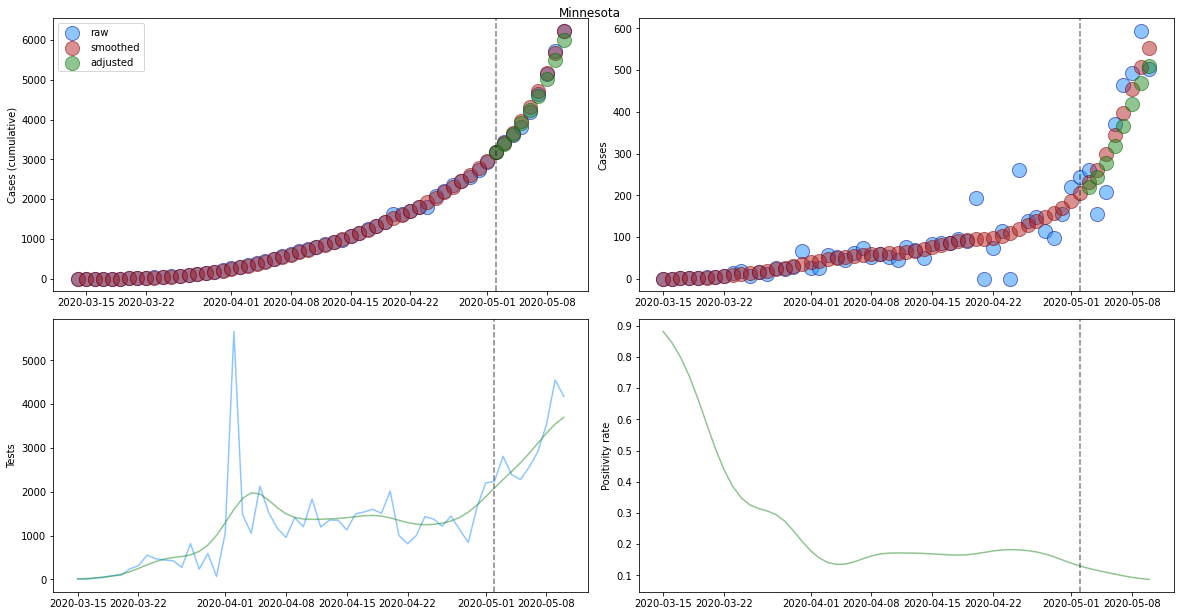

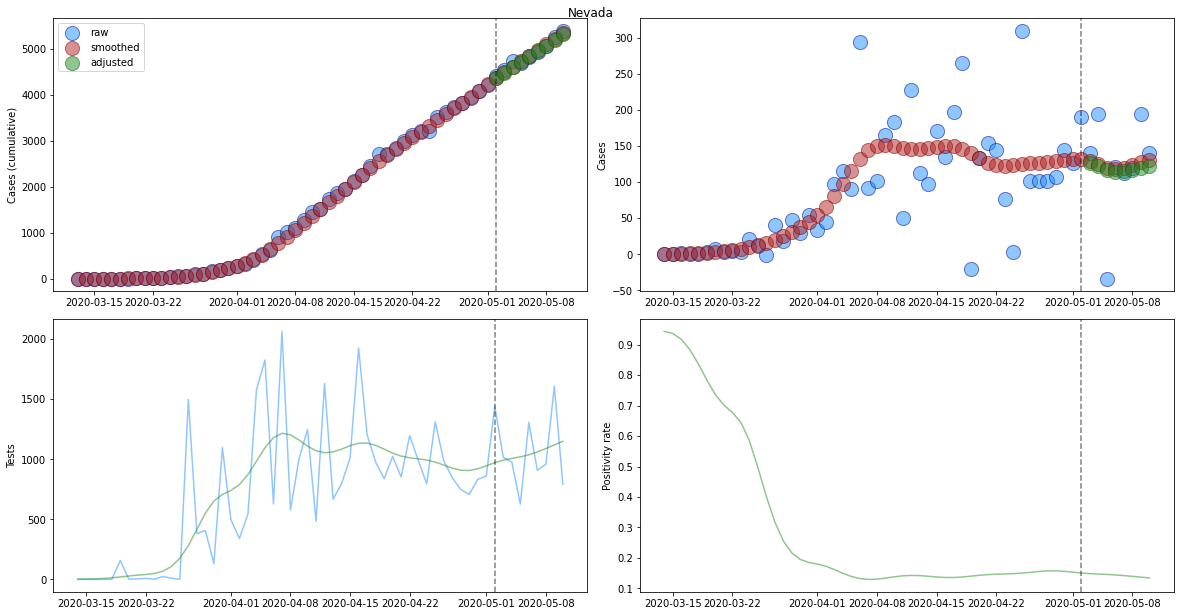

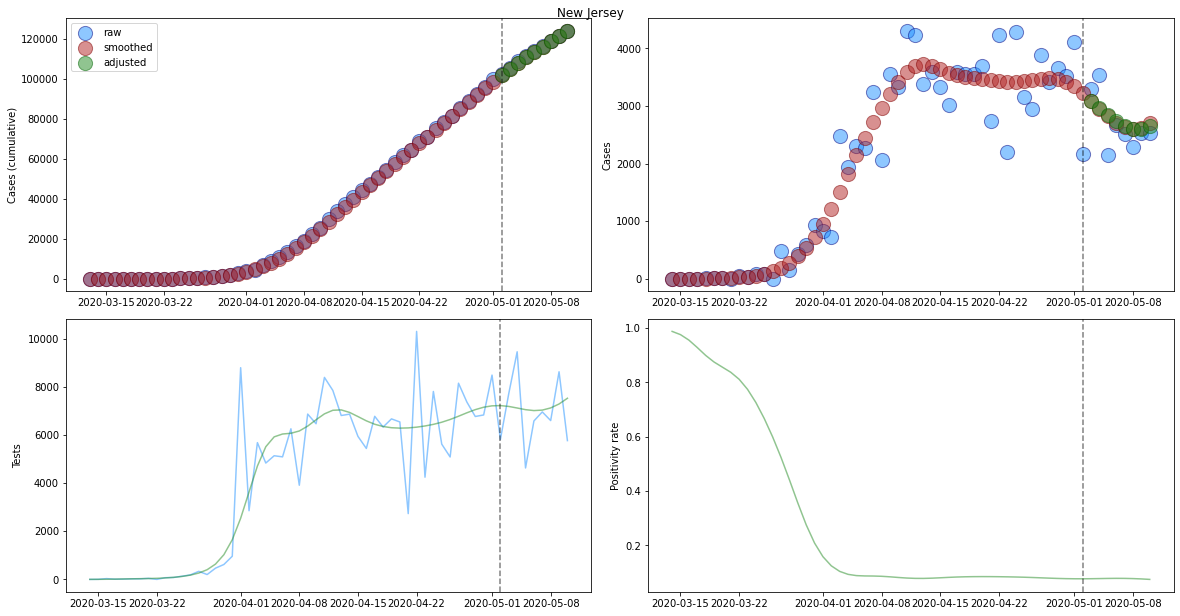

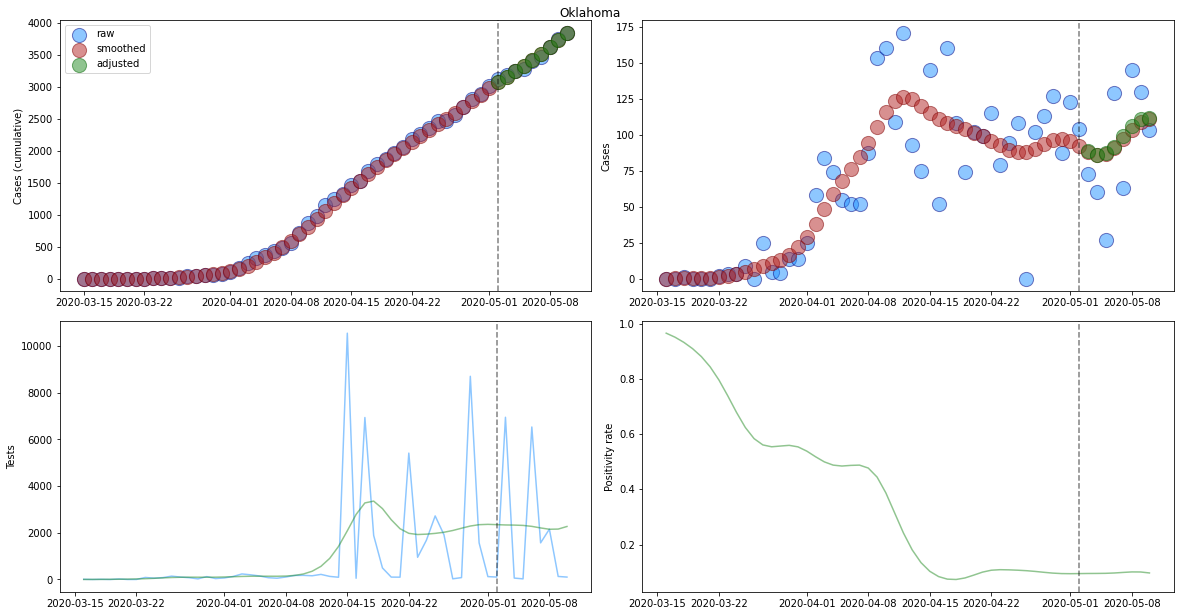

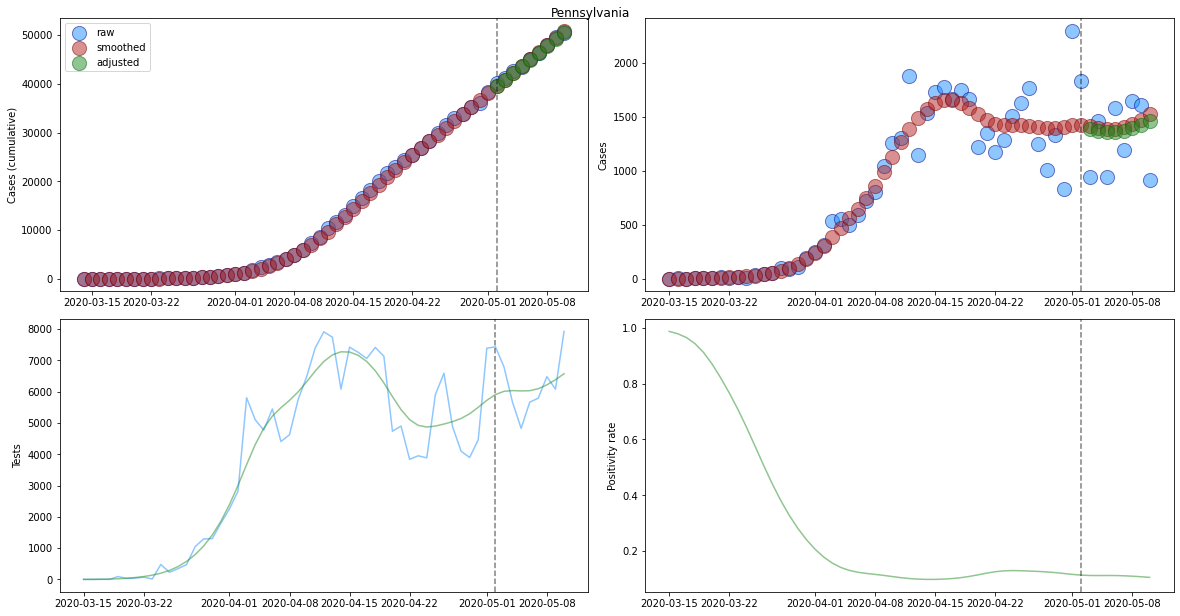

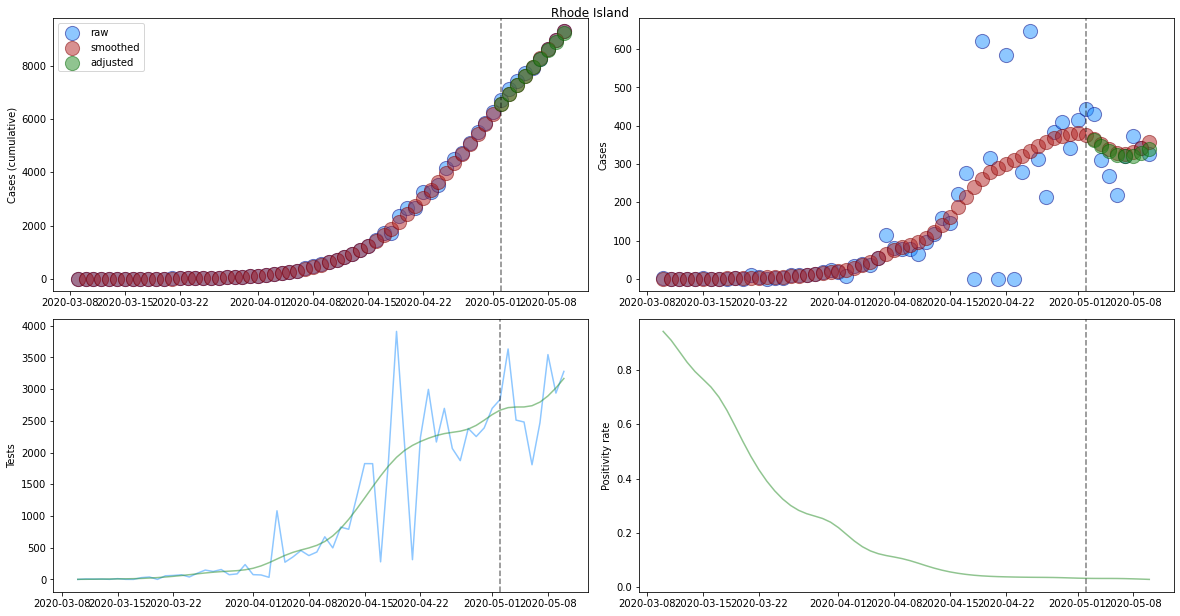

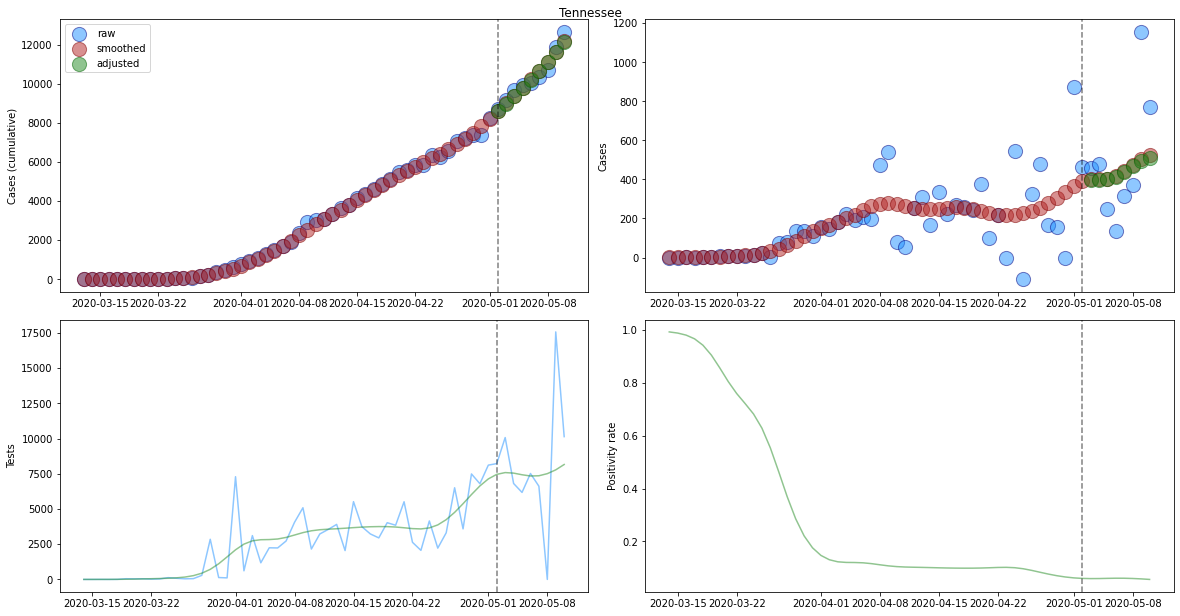

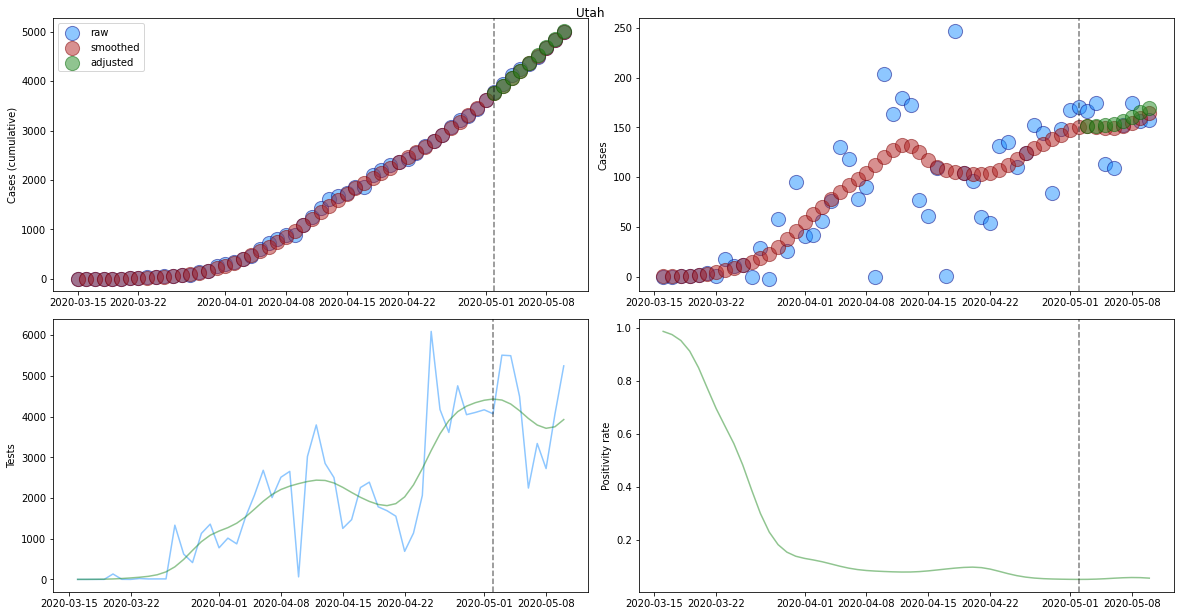

In [3]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
from db_queries import get_location_metadata

df = pd.read_csv('/ihme/homes/rmbarber/covid-19/testing_adjustment.csv')
# df_1s = pd.read_csv('/ihme/homes/rmbarber/covid-19/testing_adjustment_1smooth.csv')
# df_1s = df_1s.rename(index=str, columns={'Testing rate':'Testing rate (1 smooth)'})
# df = df.merge(df_1s[['location_id', 'Date', 'Testing rate (1 smooth)']])
df['Date'] = pd.to_datetime(df['Date'])
data_date = pd.to_datetime('2020-05-02')

loc_df = get_location_metadata(location_set_version_id=630, location_set_id=111)
loc_df = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['most_detailed'] == 1)]

logit = lambda x: np.log(x / (1 - x))
expit = lambda x: 1/(1 + np.exp(-x))

logit_pos_int = -8.05
logit_pos_logit_test = -0.78

# with PdfPages('/ihme/homes/rmbarber/covid-19/testing_adjustment_04_29.pdf') as pdf:
for location_id, location_name in zip(loc_df['location_id'], loc_df['location_name']):
    plot_df = df.loc[df['location_id'] == location_id]
    if any(~plot_df['Adjusted case rate'].isnull()):
        plot_df = plot_df.sort_values('Date').reset_index(drop=True)

        fig, ax = plt.subplots(2, 2, figsize=(16.5, 8.5))

        # cumulative cases
        ax[0,0].scatter(plot_df['Date'],
                        plot_df['Confirmed'],
                        c='dodgerblue', edgecolors='navy', s=200, alpha=0.5, label='raw')
        ax[0,0].scatter(plot_df['Date'], 
                        plot_df['Confirmed case rate'] * plot_df['population'],
                        c='firebrick', edgecolors='maroon', s=200, alpha=0.5, label='smoothed')
        ax[0,0].scatter(plot_df['Date'], 
                        plot_df['Adjusted case rate'] * plot_df['population'],
                        c='forestgreen', edgecolors='darkgreen', s=200, alpha=0.5, label='adjusted')
        ax[0,0].axvline(data_date, color='black', linestyle='--', alpha=0.5)
        ax[0,0].legend(loc=2)
        ax[0,0].set_ylabel('Cases (cumulative)')

        # daily case
        ax[0,1].scatter(plot_df['Date'][1:], plot_df['Confirmed'].values[1:] - plot_df['Confirmed'].values[:-1],
                    c='dodgerblue', edgecolors='navy', s=200, alpha=0.5)
        ax[0,1].scatter(plot_df['Date'][1:], 
                    (plot_df['Confirmed case rate'] * plot_df['population']).values[1:] - \
                    (plot_df['Confirmed case rate'] * plot_df['population']).values[:-1],
                    c='firebrick', edgecolors='maroon', s=200, alpha=0.5)
        ax[0,1].scatter(plot_df['Date'][1:], 
                    (plot_df['Adjusted case rate'] * plot_df['population']).values[1:] - \
                    (plot_df['Adjusted case rate'] * plot_df['population']).values[:-1],
                    c='forestgreen', edgecolors='darkgreen', s=200, alpha=0.5)
        ax[0,1].axvline(data_date, color='black', linestyle='--', alpha=0.5)
        ax[0,1].set_ylabel('Cases')
        
        # testing rates
        # ax[1,0].plot(plot_df['Date'], 
        #              plot_df['Tests'].values,
        #              color='dodgerblue', alpha=0.5)
        # ax[1,0].plot(plot_df['Date'], 
        #              plot_df['Testing rate'] * plot_df['population'],
        #              color='forestgreen', alpha=0.5)
        ##
        # ax[1,0].plot(plot_df['Date'][1:], 
        #            (plot_df['Testing rate (1 smooth)'] * plot_df['population']).values[1:] - \
        #            (plot_df['Testing rate (1 smooth)'] * plot_df['population']).values[:-1],
        #            color='firebrick', alpha=0.5)
        #
        ax[1,0].plot(plot_df['Date'][1:], 
                   plot_df['Tests'].values[1:] - plot_df['Tests'].values[:-1],
                   color='dodgerblue', alpha=0.5)
        ax[1,0].plot(plot_df['Date'][1:], 
                   (plot_df['Testing rate'] * plot_df['population']).values[1:] - \
                   (plot_df['Testing rate'] * plot_df['population']).values[:-1],
                   color='forestgreen', alpha=0.5)
        ax[1,0].axvline(data_date, color='black', linestyle='--', alpha=0.5)
        ax[1,0].set_ylabel('Tests')
        
        # positivity
        t = plot_df['Testing rate'].values[1:] - plot_df['Testing rate'].values[:-1]
        p = expit(logit_pos_int + logit_pos_logit_test * logit(t))
        ax[1,1].plot(plot_df['Date'][1:], 
                     p,
                     color='forestgreen', alpha=0.5)
        ax[1,1].axvline(data_date, color='black', linestyle='--', alpha=0.5)
        ax[1,1].set_ylabel('Positivity rate')

        plt.suptitle(location_name, y=1.001)
        plt.tight_layout()
        #pdf.savefig()
        plt.show()



In [5]:
df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_05_01_US_smooth10_testcorr/leading_indicator.csv')

In [6]:
df.loc[df['location_id'] == 555]

,location_id,Date,ln(age-standardized death rate),from_cases,from_hospital,source
249,555,2020-05-01,-6.699198,0.001232,NaN,cases
250,555,2020-05-02,-6.676051,0.001261,NaN,cases
251,555,2020-05-03,-6.653705,0.001289,NaN,cases
252,555,2020-05-04,-6.632705,0.001317,NaN,cases
253,555,2020-05-05,-6.613306,0.001342,NaN,cases
254,555,2020-05-06,-6.595266,0.001367,NaN,cases
255,555,2020-05-07,-6.577863,0.001391,NaN,cases
256,555,2020-05-08,-6.560141,0.001416,NaN,cases
